## Import libraries and data

In [60]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import operator #delete
import datetime
import random
from scipy import spatial
from scipy import stats
import ipyparallel # delete
from sklearn.cross_validation import StratifiedKFold

dfTrain = pd.read_csv("train.csv")
#move test to folder
dfTest = pd.read_csv("test.csv")

In [2]:
def getDigitList():
    """
    getDigitList returns a list of dataframes. Each dataframe contains the pixel values for each digit(0-9)
    """
    digitList=[]
    for i in range(10):
        digitList.append(dfTrain[dfTrain.label == i].drop("label",1).reset_index().drop("index",1)) 
    return digitList

digitsList = getDigitList()

In [3]:
def getSampleDigitList(x):
    """
    getSampleDigitList returns a list of sample digits. Each digit has 28 x 28 array dimensions
    """
    sampleDigitsList=[]
    for i in range(10):
        sampleDigitsList.append(x[i].loc[0].reshape((28,28)))
    return sampleDigitsList

sampleDigits = getSampleDigitList(digitsList)

In [4]:
print sampleDigits[0].shape

(28, 28)


## b) Write a function to display an MNIST digit

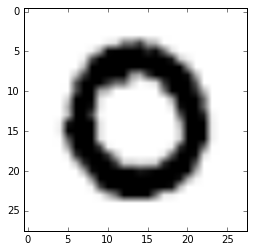

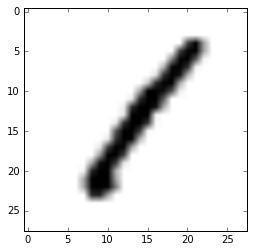

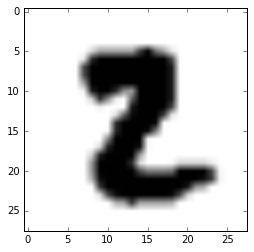

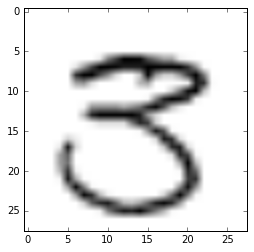

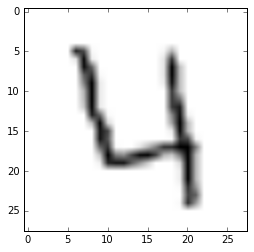

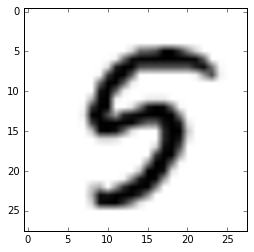

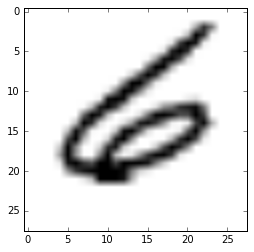

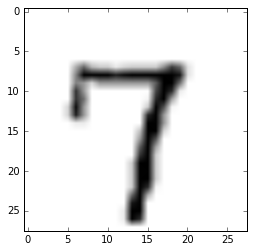

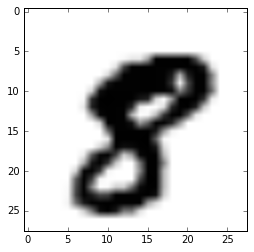

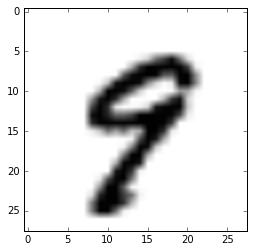

In [7]:
def plotDigits(x):
    for digit in x:
        plt.imshow(digit,cmap= cm.gray_r)
        plt.show()

plotDigits(sampleDigits)

## c) Examine the prior probability of the classes in the training data

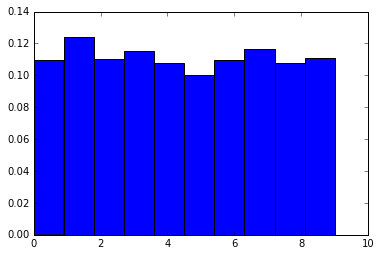

In [8]:
def plotHistogram():
    plt.hist(dfTrain.label,normed=True)
    plt.show()

plotHistogram()


## d) For each sample digit compute and show the best match between the chosen sample and the rest of the training data

In [17]:
def vicinity(sample,full):
    minDistance = None
    for val in full:
        shapedVal = val.reshape((28,28))
        distance = np.linalg.norm(sample - shapedVal) #distance == euclidean distance
        if distance == 0 or minDistance == None:
            minDistance = distance
        if minDistance > distance:
            minDistance = distance
    return minDistance

def printBestMatch(x):
    #TBD
    for distanceDict in x:
        if distanceDict["digit"] != distanceDict["closestDigit"]:
            print("digit " + str(distanceDict["digit"]) +" closest neighbor is " + str(distanceDict["closestDigit"]) 
         + " with an associated distance of " + str(distanceDict["distance"])+"*")
        else:
            print("digit " + str(distanceDict["digit"]) +" closest neighbor is " + str(distanceDict["closestDigit"]) 
         + " with an associated distance of " + str(distanceDict["distance"]))
        
           
def getNearestNeighborDistance(sampleDigits,allDigits):
    nearestDist=[]
    for i in range(10):
        sampleDigit = sampleDigits[i]
        nearestNeighbor = None
        for j in range(10):
            #start at index 1 because index 0 is the same instance as the sample
            allDigitValues = allDigits[j].values[1:] 
            distance = vicinity(sampleDigit,allDigitValues)
            if nearestNeighbor == None:
                nearestNeighbor = {"digit":i,"distance":distance,"closestDigit":j}
            else:
                if nearestNeighbor["distance"] > distance:
                    nearestNeighbor = {"digit":i,"distance":distance,"closestDigit":j}
            
        nearestDist.append(nearestNeighbor)
    printBestMatch(nearestDist)
    return nearestDist

nearestNeighborDist = getNearestNeighborDistance(sampleDigits,digitsList)

digit 0 closest neighbor is 0 with an associated distance of 1046.59543282
digit 1 closest neighbor is 1 with an associated distance of 489.679487012
digit 2 closest neighbor is 2 with an associated distance of 1380.8772574
digit 3 closest neighbor is 5 with an associated distance of 1832.66499939*
digit 4 closest neighbor is 4 with an associated distance of 1356.88098225
digit 5 closest neighbor is 5 with an associated distance of 1066.36766643
digit 6 closest neighbor is 6 with an associated distance of 1446.51132038
digit 7 closest neighbor is 7 with an associated distance of 863.501013317
digit 8 closest neighbor is 8 with an associated distance of 1593.777588
digit 9 closest neighbor is 9 with an associated distance of 910.576740314


## e) Compute pairwise distances for all genuine and impostor matches for digits 0 and 1. Plot histograms.

In [5]:
binaryDigits = digitsList[:2]
binarySample = sampleDigits[:2]

In [6]:
def getDistance(digit1,digit2):
    dist=[]
    print(len(digit1))
    print(len(digit2))
    for i in range(len(digit1)):
        for j in range(len(digit2)):
            distance = np.linalg.norm(digit1[i] - digit2[j])
            #print distance
            dist.append(distance)
    return dist

start = datetime.datetime.now()
genuineZero = getDistance(binaryDigits[0].values,binaryDigits[0].values)
zero = datetime.datetime.now()
genuineOne = getDistance(binaryDigits[1].values,binaryDigits[1].values)
one = datetime.datetime.now()
impostor = getDistance(binaryDigits[0].values,binaryDigits[1].values)
end = datetime.datetime.now()
print start
print zero
print one
print end

4132
4132
4684
4684
4132
4684
2016-09-12 17:38:51.626660
2016-09-12 17:44:26.606351
2016-09-12 17:52:02.580334
2016-09-12 18:00:42.107890


## Histogram plot of genuine zero  vs imposter pair

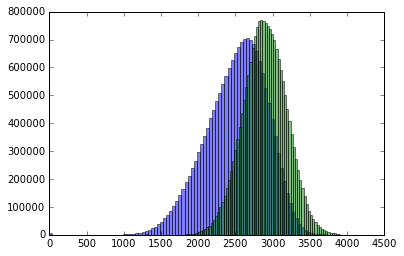

In [15]:
plt.hist(genuineZero, bins=100, alpha=.5, label="genuine")
plt.hist(impostor, bins=100, alpha=.5, label="imposter")
plt.show()

## Histogram plot of genuine one vs imposter pair

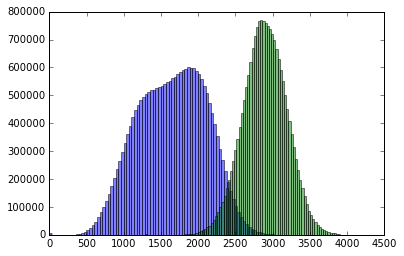

In [16]:
plt.hist(genuineOne, bins=100, alpha=.5, label="genuine")
plt.hist(impostor, bins=100, alpha=.5, label="imposter")
plt.show()

## f) Generate ROC curve

## Sensitivity and Specificity Note:
- TP: imposter correctly identified as imposter
- TN: genuine correctly identified as genuine
- FP: genuine incorrectly identified as imposter
- FN: imposter incorrectly identified as genuine




|  | Genuine | Imposter |
|:-----------|------------:|:------------:|
| Genuine      |       TP |     FN    
| Imposter     |       FP|    TN   
* rows = actual 
* columns = predictions


In [7]:
def getROCRates(gen,imp,thRate):
    tpr = []
    fpr = []
    
    th = 0
    genIdx = 0
    impIdx = 0
    
    tp = 0
    fp = 0
    tn = len(imp) - tp
    fn = len(gen) - fp
    
    while th < max(gen[-1],imp[-1]):
        
        for i in xrange(genIdx,len(gen)):
            #with classification, we want the genuine matches to be as low as possible. Hence,
            # we look for genuines that are below the threshold
            if gen[i] <= th:
                tp+=1
                fn = len(gen) - tp
                genIdx+=1
            else:
                break
        for j in xrange(impIdx,len(imp)):
            if imp[j] < th:
                fp+=1
                tn = len(imp) - fp
                impIdx+=1
            else:
                break
                
        tpr.append(float(tp)/(tp + fn))
        fpr.append(float(fp)/(fp + tn))
        th+=thRate
    
    rates ={"tpr":tpr,"fpr":fpr}
    return rates

ratesZero = getROCRates(sorted(genuineZero),sorted(impostor),100)
ratesOne = getROCRates(sorted(genuineOne),sorted(impostor),100)

## ROC curve for zero

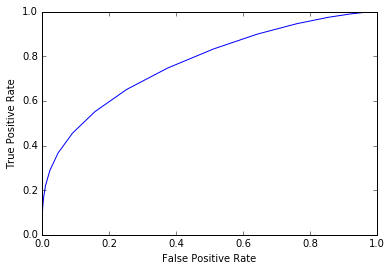

In [56]:
plt.plot(ratesZero["fpr"],ratesZero["tpr"])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## ROC curve for one

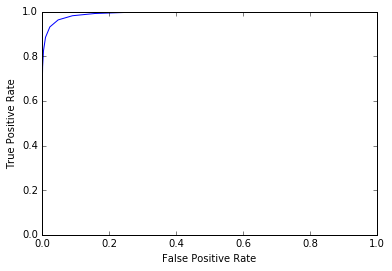

In [55]:
plt.plot(ratesOne["fpr"],ratesOne["tpr"])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## Equal Error Rate

The equal error rate is the rate at which the false acceptance rate ( false positive ) and false rejection rate(false negative) are equal. The EER is also when the false acceptance rate = 1 - true positive rate.

In [58]:
def EER(fpr,tpr):
    """EER prints the fpr,1-tpr,i(index of EER value) and round EER value"""
    for i in range(len(fpr)):
        if round(fpr[i],1) == round(1 - tpr[i],1):
            print fpr[i], 1 - tpr[i],i,round(fpr[i],1)

In [59]:
EER(ratesZero["fpr"],ratesZero["tpr"])
print
EER(ratesOne["fpr"],ratesOne["tpr"])

0.252359787144 0.348678859027 27 0.3

0.0475817555262 0.0372141002202 24 0.0


 The EER for the ROC curve of zeros is approx. 0.3, while the EER for the ROC curve of ones is approx. 0.04

### g) Implement a K-NN classifier

In [4]:
def getDistanceMatrix(train,test):
    dist = spatial.distance.cdist(test, train)
    return dist.argsort(axis=1)
    
def computePredictions(distance,labels,k):
    pred = []
    neighborsLabels= getNeighborsLabels(distance[:,0:k],labels)
    map(lambda x:pred.append(random.choice(stats.mode(x)[0])),neighborsLabels)
    #random.choice() breaks ties at random   
    return pred

def getNeighborsLabels(dist,labels):
    neighborsLabels = [[labels[x] for x in arr] for arr in dist]
    return neighborsLabels
    

def kNN(train,test,trainLabels,k):
    distanceMatrix = getDistanceMatrix(train,test)
    predictions = computePredictions(distanceMatrix,trainLabels,k)
    return predictions
    

## Test run - time

In [7]:
s =  datetime.datetime.now()
preds = kNN(dfTrain.drop("label",1).values,dfTest.values,dfTrain["label"].values,5)
e =  datetime.datetime.now()

##It now takes ~ 30 minutes to run on the full train/test data

print s
print e


got the distance matrix
computing predictions
got the neighbors
2016-09-07 11:08:05.811008
2016-09-07 11:38:34.720259


## h) perform 3 fold cross-validation & i) Generate a 10 X 10 confusion matrix

In [6]:
def checkLabelDistribution(train,test,i):
    plt.title("train_fold " +str(i))
    plt.hist(train,normed=True,label="train_fold " +str(i))
    plt.show()
    plt.title("test_fold " +str(i))
    plt.hist(test,normed=True,label="test_fold " +str(i))
    plt.show()
        
def crossValidate(skf,k,startK):
    data = dfTrain
    i = 0
    accArray = []
    for trainIdx,testIdx in skf:
        checkLabelDistribution(trainIdx,testIdx,i)
        trainData = data.drop("label",1).iloc[trainIdx]
        trainLabels = data["label"].iloc[trainIdx]
        testData = data.drop("label",1).iloc[testIdx]
        testLabels = data["label"].iloc[testIdx]
        predictions = kNN(trainData.values,testData.values,trainLabels.values,k)
        acc = 1 - np.mean(testLabels != np.array(predictions))
        print " In Fold " + str(i) + ",with k = " + str(k) + " the accuracy was measured to be " + str(acc) + "."
        accArray.append(acc)
        i+=1
    return accArray

        
def computeCrossValidation(data,startK,maxK):
    #StratifiedKFold takes a 1-D array to be divided into Folds and outputs indices
    skf =  StratifiedKFold(data["label"].values,3)
    bestK = startK
    bestAcc = 0
    k = startK
    while k <= maxK:
        acc = np.mean(crossValidate(skf,k,startK))
        if acc > bestAcc:
            bestAcc = acc
            bestK = k
        k+=2
    print "The best k and accuracy were: " + str(bestK) + ", " + str(bestAcc) 
    return bestK




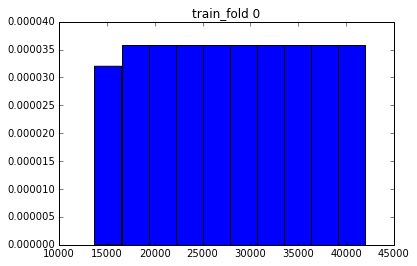

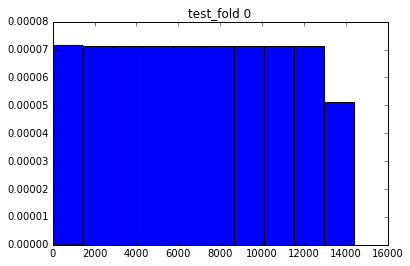

 In Fold 0,with k = 5 the accuracy was measured to be 0.964581548129.


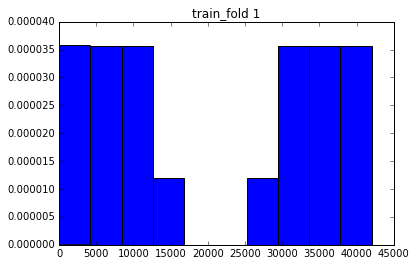

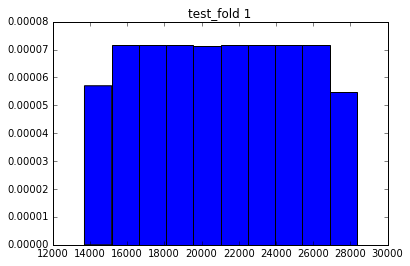

 In Fold 1,with k = 5 the accuracy was measured to be 0.963280468638.


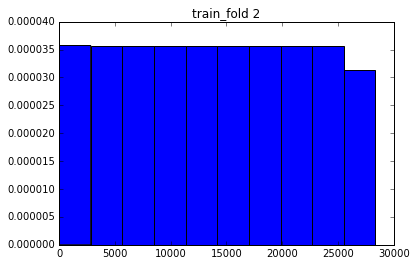

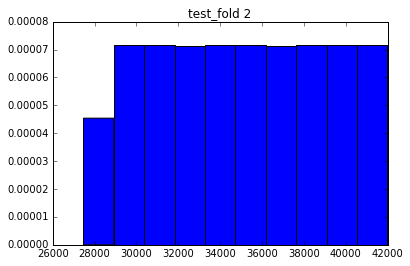

 In Fold 2,with k = 5 the accuracy was measured to be 0.964780682955.


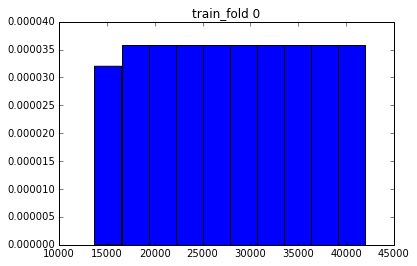

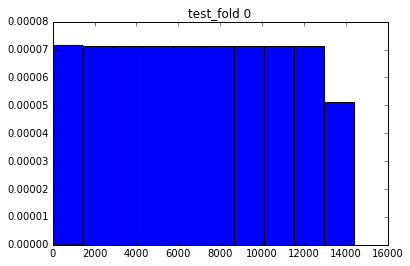

 In Fold 0,with k = 7 the accuracy was measured to be 0.963153384747.


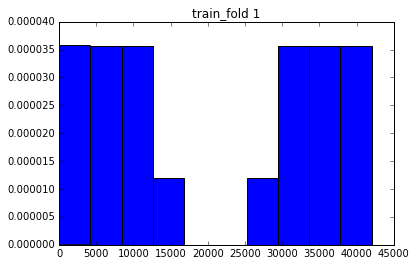

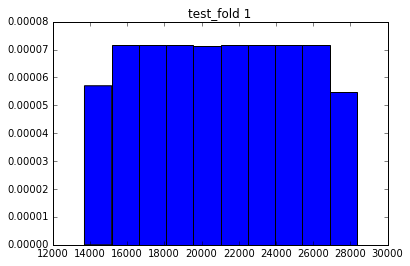

 In Fold 1,with k = 7 the accuracy was measured to be 0.962137448207.


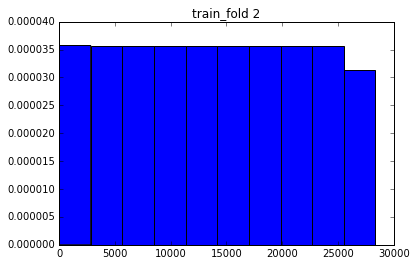

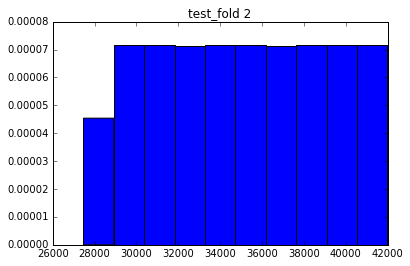

 In Fold 2,with k = 7 the accuracy was measured to be 0.963423346192.


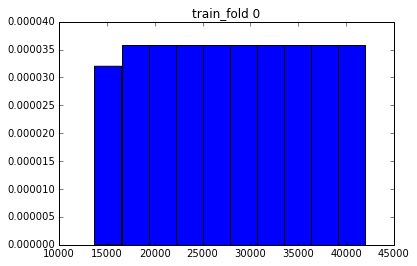

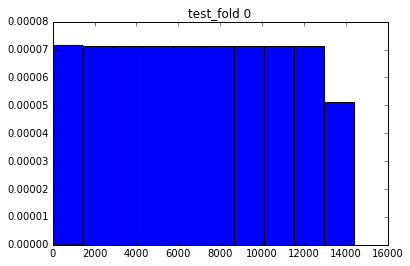

 In Fold 0,with k = 9 the accuracy was measured to be 0.960439874322.


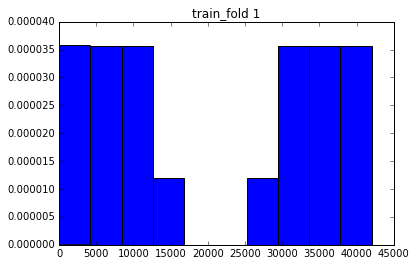

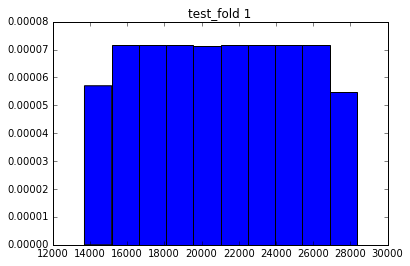

 In Fold 1,with k = 9 the accuracy was measured to be 0.961208744106.


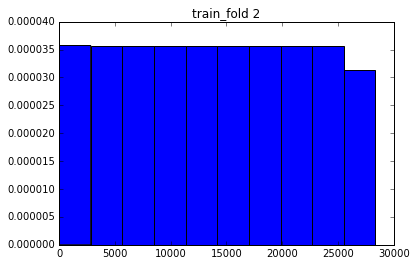

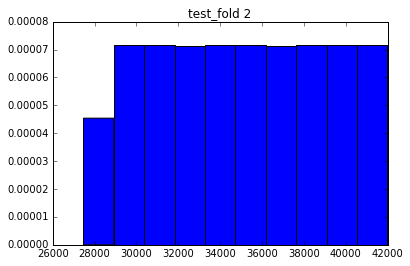

 In Fold 2,with k = 9 the accuracy was measured to be 0.962708958423.


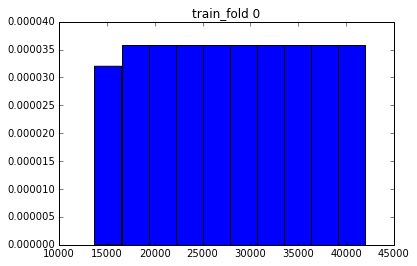

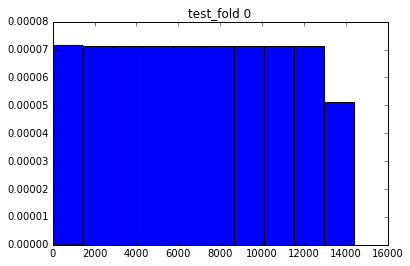

 In Fold 0,with k = 11 the accuracy was measured to be 0.959154527278.


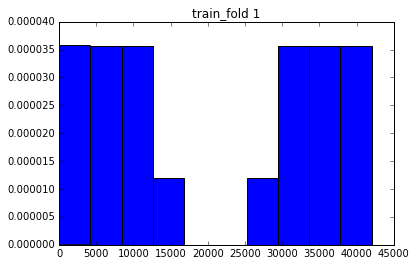

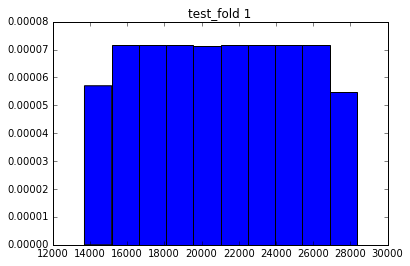

 In Fold 1,with k = 11 the accuracy was measured to be 0.959279897128.


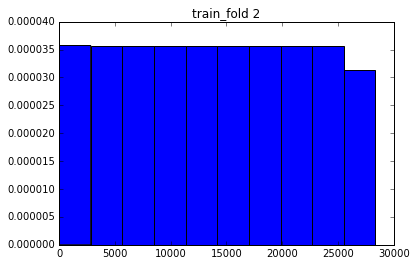

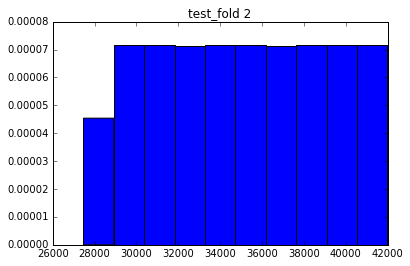

 In Fold 2,with k = 11 the accuracy was measured to be 0.960494356337.
The best k and accuracy were: 5, 0.964214233241
2016-09-08 10:23:04.671432
2016-09-08 12:21:02.565845
5


In [7]:
time1=  datetime.datetime.now()
optimalK = computeCrossValidation(dfTrain,5,11)
time2 =  datetime.datetime.now()

print time1
print time2
print optimalK

##  i) Generate a confusion matrix (of size 10 × 10)

In [50]:
def generateConfusionMatrix(prediction,actual):
    confusionMatrix = np.zeros((10,10))
    for i in range(len(actual)):
            confusionMatrix[prediction[i]][actual[i]] += 1
    return pd.DataFrame(confusionMatrix)

def getConfusionMatrix(data,kVal):
    skf =  StratifiedKFold(data["label"].values,3)
    i = 1
    for trainIdx,testIdx in skf:
        trainData = data.drop("label",1).iloc[trainIdx]
        trainLabels = data["label"].iloc[trainIdx]
        testData = data.drop("label",1).iloc[testIdx]
        testLabels = data["label"].iloc[testIdx]
        predictions = kNN(trainData.values,testData.values,trainLabels.values,kVal)
        print "The confusion matrix for fold " + str(i) + " is :"
        print generateConfusionMatrix(predictions,testLabels.values)
        i+=1
            

The following are the matrices for fold 1,2,3 at k = 5.

In [51]:
getConfusionMatrix(dfTrain,5)

The confusion matrix for fold 1 is :
      0     1     2     3     4     5     6     7     8     9
0  1366     0    10     1     0     2     8     1     8     4
1     1  1553    23     4    17     3     2    26    11     3
2     2     2  1322     7     0     2     0     3     7     0
3     0     2     4  1408     0    24     0     0    27    10
4     0     0     2     0  1304     0     2     5     4    15
5     2     0     1    17     0  1208     3     0    33     2
6     6     2     0     0     5    14  1364     0     9     1
7     1     0    25     5     3     1     0  1415     7    23
8     0     1     4     6     0     3     0     0  1233     3
9     0     2     2     3    29     8     0    17    16  1335
The confusion matrix for fold 1 is :
      0     1     2     3     4     5     6     7     8     9
0  1367     0     7     2     2     4     8     0     6     4
1     0  1549    20     2    17     1     3    21    12     4
2     2     5  1320    10     0     0     0     3     7   

According to the confusion matrices above,the trickiest digits to classify are 1 and 9.

## j) train classifier and submit results

In [110]:
#cross-validation proved that the best performing k value was 5
predictions = kNN(dfTrain.drop("label",1).values,dfTest.values,dfTrain["label"].values,optimalK)

def saveToCSV(lst):
    header = ['Label']
    numpLst = np.array(lst)
    dataFrame = pd.DataFrame(numpLst,columns=header)
    dataFrame.index.name = 'ImageId'
    dataFrame.index += 1
    dataFrame.to_csv("submissionPredictions.csv",sep =",")
    
saveToCSV(predictions)